In [ ]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import LMAPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [ ]:
%load_ext autoreload
%autoreload 2

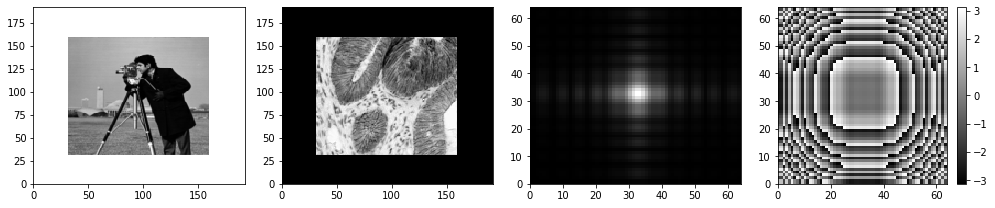

In [3]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e4)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

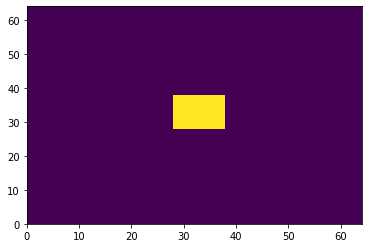

In [4]:
probe_guess = np.zeros_like(ptsim._probe_true)
probe_guess[28:38, 28:38] = 1
probe_guess = probe_guess * np.sqrt(ptsim._probe_n_photons/np.sum(np.abs(probe_guess)**2))
plt.pcolormesh(np.abs(probe_guess))
plt.show()

## LMA - reconstructing the obj and probe

In [36]:
recons_cg_iters = {}

In [37]:
obj_guess = (np.random.randn(*ptsim._obj_true.shape) 
             * np.exp(1j * 2 * np.pi * np.random.randn(*ptsim._obj_true.shape)))

In [ ]:
for loss_type in ["gaussian", "poisson", "poisson_surrogate"]:
    for probe_recons in [True, False]:
        for i in [5, 10, 20, 50]:
            for ctol in [1e-2, 1e-3, 1e-4, 1e-5]:
                for clip in [True, False]:
                    pr = LMAPhaseRetriever(ptsim=ptsim, 
                                           probe_recons=probe_recons, 
                                           probe_guess_cmplx_2d=probe_guess,
                                           obj_guess_cmplx_2d=obj_guess,
                                           validation_ndiffs=0,
                                           loss_type=loss_type)
                    print(pr._loss_type, i, ctol)
                    #raise
                    pr.setOptimizingParams(max_cg_iter=i, cg_tol=ctol)
                    pr.initSession()
                    try:
                        pr.run(patience=100, debug_output_epoch_frequency=50, obj_clip=clip)
                    except ArithmeticError:
                        pass
                    print(pr.data.tail(1))
                    recons_cg_iters[(loss_type, 
                                     probe_recons, 
                                     i, 
                                     ctol, 
                                     clip)] = (
                        pr.data.index[-1], 
                        pr.session.run(pr._optparams.obj_optimizer._total_cg_iterations), 
                        pr.data["obj_error"][pr.data.index[-1]],
                        pr.data["probe_error"][pr.data.index[-1]])

In [74]:
save_load = input("Enter s to save, l to load.")
if save_load == 's':
    np.save('lma_vanilla_cg_iters', recons_cg_iters)
elif save_load == 'l':
    recons_cg_iters = np.load("lma_vanilla_cg_iters.npy", allow_pickle=True).item()

Enter s to save, l to load. l


## Regularized LMA

In [ ]:
regularized_recons_cg_iters = {}
for loss_type in ["gaussian", "poisson", "poisson_surrogate"]:
    for probe_recons in [True, False]:
        for i in [5, 10, 20, 50]:
            for ctol in [1e-2, 1e-3, 1e-4, 1e-5]:
                for clip in [True, False]:
                    pr = LMAPhaseRetriever(ptsim=ptsim, 
                                           probe_recons=probe_recons, 
                                           probe_guess_cmplx_2d=probe_guess,
                                           obj_guess_cmplx_2d=obj_guess,
                                           validation_ndiffs=0,
                                           loss_type=loss_type)
                    print(pr._loss_type, i, ctol)
                    #raise
                    pr.setOptimizingParams(max_cg_iter=i, cg_tol=ctol, lma_regularized=True)
                    pr.initSession()
                    try:
                        pr.run(patience=100, debug_output_epoch_frequency=50, obj_clip=clip)
                    except ArithmeticError:
                        pass
                    print(pr.data.tail(1))
                    regularized_recons_cg_iters[(loss_type, 
                                     probe_recons, 
                                     i, 
                                     ctol, 
                                     clip)] = (
                        pr.data.index[-1], 
                        pr.session.run(pr._optparams.obj_optimizer._total_cg_iterations), 
                        pr.data["obj_error"][pr.data.index[-1]],
                        pr.data["probe_error"][pr.data.index[-1]])

In [78]:
save_load = input("Enter s to save, l to load.")
if save_load == 's':
    np.save('lma_regularized_cg_iters', regularized_recons_cg_iters)
elif save_load == 'l':
    regularized_recons_cg_iters = np.load("lma_regularized_cg_iters.npy", allow_pickle=True).item()

Enter s to save, l to load. s


In [ ]:
regularized_recons_cg_iters_2 = {}
for loss_type in ["gaussian", "poisson", "poisson_surrogate"]:
    for probe_recons in [True, False]:
        for i in [5, 10, 20, 50]:
            for ctol in [1e-2, 1e-3, 1e-4, 1e-5]:
                for clip in [True, False]:
                    pr = LMAPhaseRetriever(ptsim=ptsim, 
                                           probe_recons=probe_recons, 
                                           probe_guess_cmplx_2d=probe_guess,
                                           obj_guess_cmplx_2d=obj_guess,
                                           validation_ndiffs=0,
                                           loss_type=loss_type)
                    print(pr._loss_type, i, ctol)
                    #raise
                    pr.setOptimizingParams(max_cg_iter=i, cg_tol=ctol, lma_regularized=True)
                    pr.initSession()
                    try:
                        pr.run(patience=100, debug_output_epoch_frequency=50, obj_clip=clip)
                    except ArithmeticError:
                        pass
                    print(pr.data.tail(1))
                    regularized_recons_cg_iters_2[(loss_type, 
                                     probe_recons, 
                                     i, 
                                     ctol, 
                                     clip)] = (
                        pr.data.index[-1], 
                        pr.session.run(pr._optparams.obj_optimizer._total_cg_iterations), 
                        pr.data["obj_error"][pr.data.index[-1]],
                        pr.data["probe_error"][pr.data.index[-1]])

In [86]:
save_load = input("Enter s to save, l to load.")
if save_load == 's':
    np.save('lma_regularized_cg_iters_power_2', regularized_recons_cg_iters_2)
elif save_load == 'l':
    regularized_recons_cg_iters_2 = np.load("lma_regularized_cg_iters_power_2.npy", allow_pickle=True).item()

Enter s to save, l to load. s


In [87]:
for i1, i2, i3 in zip(recons_cg_iters.items(), 
                      regularized_recons_cg_iters.items(),
                      regularized_recons_cg_iters_2.items()):
    print(i1, i2, i3)

(('gaussian', True, 5, 0.01, True), (54, 374, 0.15117346, nan)) (('gaussian', True, 5, 0.01, True), (60, 290, 0.15121488, nan)) (('gaussian', True, 5, 0.01, True), (72, 287, 0.15120865, nan))
(('gaussian', True, 5, 0.01, False), (100, 505, 0.6043246, nan)) (('gaussian', True, 5, 0.01, False), (91, 443, 0.15120873, nan)) (('gaussian', True, 5, 0.01, False), (100, 421, 0.15115918, nan))
(('gaussian', True, 5, 0.001, True), (55, 360, 0.1511577, nan)) (('gaussian', True, 5, 0.001, True), (60, 295, 0.15119949, nan)) (('gaussian', True, 5, 0.001, True), (72, 296, 0.1512009, nan))
(('gaussian', True, 5, 0.001, False), (100, 505, 0.6036184, nan)) (('gaussian', True, 5, 0.001, False), (91, 448, 0.15121633, nan)) (('gaussian', True, 5, 0.001, False), (100, 431, 0.15115853, nan))
(('gaussian', True, 5, 0.0001, True), (56, 370, 0.15115769, nan)) (('gaussian', True, 5, 0.0001, True), (60, 299, 0.1512012, nan)) (('gaussian', True, 5, 0.0001, True), (72, 307, 0.1511991, nan))
(('gaussian', True, 5, 0

## Working with a high photon count

In [ ]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e8)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

In [ ]:
probe_guess = np.zeros_like(ptsim._probe_true)
probe_guess[28:38, 28:38] = 1
probe_guess = probe_guess * np.sqrt(ptsim._probe_n_photons/np.sum(np.abs(probe_guess)**2))
plt.pcolormesh(np.abs(probe_guess))
plt.show()